In [1]:
#Loading the Data
import pandas as pd
aisles = pd.read_csv('C:/Users/Kunal/Desktop/mohita/Project/aisles.csv')
departments = pd.read_csv('C:/Users/Kunal/Desktop/mohita/Project/departments.csv')
order_products_prior = pd.read_csv('C:/Users/Kunal/Desktop/mohita/Project/order_products_prior.csv')
order_products_train = pd.read_csv('C:/Users/Kunal/Desktop/mohita/Project/order_products__train.csv')
orders = pd.read_csv('C:/Users/Kunal/Desktop/mohita/Project/orders.csv')
products = pd.read_csv('C:/Users/Kunal/Desktop/mohita/Project/products.csv')
sample_submission = pd.read_csv('C:/Users/Kunal/Desktop/mohita/Project/sample_submission.csv')

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

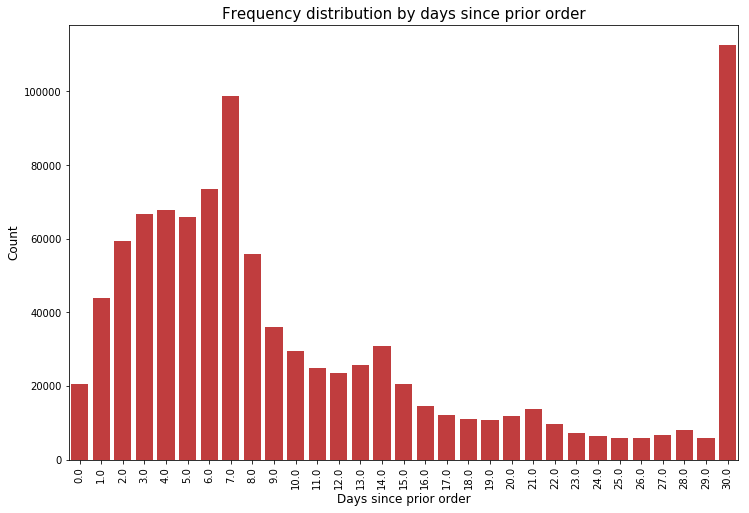

In [5]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

In [11]:
order_products_train_df = pd.merge(order_products_train, orders, on='order_id', how='left')
grouped_df = order_products_train_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

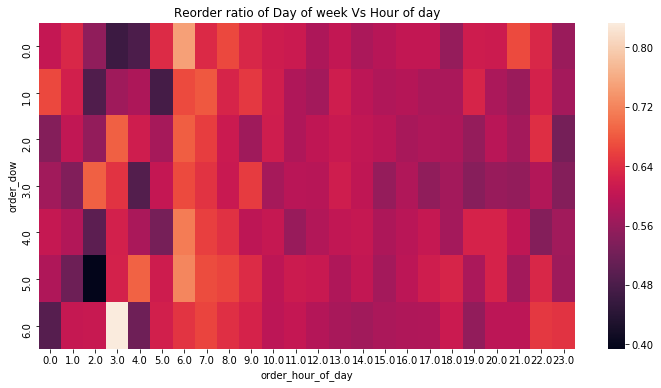

In [14]:
grouped_df = order_products_train_df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')
plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

In [ ]:
order_products_prior_df = pd.merge(order_products_prior, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df.head()

In [2]:
#Merging relevant datasets
result = [order_products_prior,order_products_train]
#result
order_products_all = pd.concat(result)
order_products_all
merge_data_orders=pd.merge(order_products_all,orders,on="order_id",how="left").sort_values(by='user_id')
merge_data_orders=pd.merge(merge_data_orders,products,on="product_id",how="left")
merge_data_orders['order_dow'].replace([0,1,2,3,4,5,6],['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],inplace=True)
merge_data_orders.head()


MemoryError: 

In [3]:
#Maximum sold product from market basket; selecting top 10 products only
trial = merge_data_orders.groupby(['product_name'],as_index=False)['product_id'].count()
trial=trial.sort_values('product_id',ascending=False)
Max_sold_product=pd.merge(trial,products,on="product_name",how="right")
del Max_sold_product['aisle_id']
Max_sold_product.columns=['Product_name','Total_sales_qty','Product_id','Department_id']
Max_sold_product=Max_sold_product.head(10)
Max_sold_product['Total_sales_qty']=Max_sold_product['Total_sales_qty'].astype('int64')
Max_sold_product

,Product_name,Total_sales_qty,Product_id,Department_id
0,Banana,491291,24852,4
1,Bag of Organic Bananas,394930,13176,4
2,Organic Strawberries,275577,21137,4
3,Organic Baby Spinach,251705,21903,4
4,Organic Hass Avocado,220877,47209,4
5,Organic Avocado,184224,47766,4
6,Large Lemon,160792,47626,4
7,Strawberries,149445,16797,4
8,Limes,146660,26209,4
9,Organic Whole Milk,142813,27845,16


In [5]:
#Peak hours of the day by counting products ordered at that time
order_time=merge_data_orders['order_hour_of_day'].value_counts().to_frame()
order_time['hour_of_day']=order_time.index
order_time.columns=['count','hour_of_day']
order_time=order_time.head(10)
order_time


,count,hour_of_day
10,2874905,10
11,2852701,11
14,2810918,14
15,2780731,15
13,2778054,13
12,2732599,12
16,2647695,16
9,2550569,9
17,2186409,17
8,1787359,8


In [6]:
#Top 5 products by total sales and how much percentage on which day 
trial.columns=['Product_name','Total_sales_qty']
trial=trial.head(5)
trial["Day_of_week"]=""
trial["Max_sold_day"]=""

for index, row in trial.iterrows():
    y=merge_data_orders[merge_data_orders['product_name']==row['Product_name']].groupby('order_dow')['product_id'].count()
    y=y.sort_values(ascending=False)
    trial.at[index, 'Max_sold_day']=y[0]
    trial.at[index, 'Day_of_week']=y.index[0]

for index, row in trial.iterrows():
    trial.at[index, 'Percentage']=(row['Max_sold_day']/row['Total_sales_qty'])*100

trial['Percentage']=trial['Percentage'].round(2)
trial

,Product_name,Total_sales_qty,Day_of_week,Max_sold_day,Percentage
3677,Banana,491291,Mon,101474,20.65
3472,Bag of Organic Bananas,394930,Mon,75052,19.00
31923,Organic Strawberries,275577,Mon,56635,20.55
28843,Organic Baby Spinach,251705,Mon,57556,22.87
30300,Organic Hass Avocado,220877,Mon,45841,20.75


In [7]:
#locate top 5 users with maximum qty purchase
  users=merge_data_orders.groupby('user_id')['product_id'].count().sort_values(ascending=False)
users=users.head(5).to_frame()

users['User_id']=users.index
users=users.rename(columns={'product_id':'Total_units_buy'})
users

,Total_units_buy,User_id
user_id,,
201268,3725,201268
129928,3689,129928
164055,3089,164055
176478,2952,176478
186704,2936,186704


In [13]:
#For top 5 users, which department they maximum purchased from and what qty
topdept=pd.DataFrame()
for x in users['User_id']:
    y=merge_data_orders[merge_data_orders['user_id']==x].groupby(['department_id'],as_index=False)['product_id'].count()
    y=y.sort_values(by='product_id',ascending=False)
    y=y.head(1)
    y['User_id']=[x]
    topdept=topdept.append(y,ignore_index=True)
topdept['User_id']=topdept['User_id'].astype('int64')
topdept=topdept[['User_id','department_id','product_id']]
topdept.columns=['User_id','Department_id','Departmental_buy']
topdept

,User_id,Department_id,Departmental_buy
0,201268,16,951
1,129928,19,1207
2,164055,16,621
3,176478,7,505
4,186704,16,765


In [14]:
# reorganize and clean the above table to find out what % of total purchase of individual top 5 users
# This % is of the max departmental purchase and reflects from which dept
top_users=pd.merge(topdept,users,on="User_id",how='right')
top_users.columns=['User_id','Department_id','Departmental_buy','Total_units_buy']
top_users["Percentage_buy"]=((top_users['Departmental_buy']/top_users['Total_units_buy'])*100).round(2)
top_users

,User_id,Department_id,Departmental_buy,Total_units_buy,Percentage_buy
0,201268,16,951,3725,25.53
1,129928,19,1207,3689,32.72
2,164055,16,621,3089,20.10
3,176478,7,505,2952,17.11
4,186704,16,765,2936,26.06


In [15]:

order_week=orders['order_dow'].value_counts().to_frame()
order_week['day_of_week']=order_week.index
order_week.columns=['count','day_of_week']
order_week.sort_values('count',ascending=False)
order_week['day_of_week'].replace([0,1,2,3,4,5,6],['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],inplace=True)
order_week

,count,day_of_week
0,600905,Mon
1,587478,Tue
2,467260,Wed
5,453368,Sat
6,448761,Sun
3,436972,Thu
4,426339,Fri


In [17]:
# Recommend 1: Recommendation based on the historical purchases of this user(top user):
histrec=merge_data_orders[merge_data_orders['user_id']==201268]
histrec=histrec[histrec['department_id']==16].groupby(['user_id','product_name'],as_index=False)['product_id'].count().sort_values(by='product_id',ascending=False).head(10)
histrec.columns=['User_id','Product_name','Count']
histrec

,User_id,Product_name,Count
6,201268,Feta Cheese Crumbles,56
9,201268,Goat Cheese Crumbles,51
63,201268,Whipped Cream Cheese,44
46,201268,Shredded Parmesan,42
10,201268,Half & Half,41
4,201268,Emmentaler Swiss Slices,39
58,201268,Unsweetened Almondmilk,39
26,201268,Organic Fat Free Milk,38
23,201268,Non Fat Raspberry Yogurt,34
32,201268,Organic Milk,33


In [18]:
# Recommend 2: Recommendation of similar departmental products based on the their choice from same top dept (content based recommendation):
futrec=merge_data_orders[merge_data_orders['user_id']==201268]
futrec=futrec[futrec['department_id']==16].groupby(['user_id','product_name'],as_index=False)['product_id'].count().sort_values(by='product_id',ascending=False).tail(10)
futrec.columns=['User_id','Product_name','Count']
futrec

,User_id,Product_name,Count
15,201268,"Milk, Organic, Fat Free",1
31,201268,Organic Lemon Lowfat Yogurt,1
52,201268,Total 0% Greek Yogurt,1
34,201268,Organic Peach Lowfat Yogurt,1
49,201268,Strained Whole-Milk Yogurt Blueberry,1
38,201268,Organic Shredded Mild Cheddar,1
39,201268,Organic Whipped Naturally Buttery Spread,1
45,201268,Shredded Mild Cheddar Cheese,1
44,201268,Sharp Cheddar Thick Slices Cheese,1
0,201268,"Almondmilk Creamer, Vanilla",1


In [19]:
# Recommend 3:Recommendation based on direct exit to cart checkout:
top_3=topdept['User_id'].head(3)
cartrec=pd.DataFrame()
for x in top_3:
    j=merge_data_orders[merge_data_orders['user_id']==x].groupby(['department_id'],as_index=False)['product_id'].count()
    j=j.sort_values(by='product_id',ascending=False)
    j=j.head(3)
    for y in j['department_id']:
        prod_3=merge_data_orders[merge_data_orders['user_id']==x]
        prod_3=prod_3[prod_3['department_id']==y].groupby(['user_id','product_name'],as_index=False)['product_id'].count().sort_values(by='product_id',ascending=False).head(3)
        prod_3["Department_id"]=[y,y,y]
        cartrec=cartrec.append(prod_3,ignore_index=True)
        
cartrec

,user_id,product_name,product_id,Department_id
0,201268,Feta Cheese Crumbles,56,16
1,201268,Goat Cheese Crumbles,51,16
2,201268,Whipped Cream Cheese,44,16
3,201268,Roasted & Salted Almonds,46,19
4,201268,Boomchickapop Sea Salt Popcorn,44,19
5,201268,Peanut Butter Bar,44,19
6,201268,Organic Lacinato (Dinosaur) Kale,62,4
7,201268,Bag of Organic Bananas,54,4
8,201268,Baby Arugula,42,4
9,129928,Organic Calimyrna Figs,43,19
